In [1]:
import subtractr
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import circuitmap
from circuitmap.neural_waveform_demixing import NeuralDemixer
from circuitmap.simulation import simulate_continuous_experiment
import subtractr.photocurrent_sim as pcsim
from subtractr.photocurrent_sim import sample_jittered_photocurrent_shapes, split_overlapping, monotone_decay_filter
from tqdm import tqdm
from functools import partial

/home/ba2617/.conda/envs/subtraction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stim_dur_ms=5
prior_context=100
response_length=1800
stim_freq=30
N=100
sampling_freq=20000
expt = simulate_continuous_experiment(N=N, stim_freq=stim_freq, expt_len=int(3 * 20000),
                                      prior_context=prior_context, response_length=response_length,)

Creating simulation with specifications:
Population size 100
Hologram targets 10
Response window (frames) 1800
Stimulus frequency (Hz) 30
Experiment duration (s) 3.00
Sampling frequency (KHz) 20.0
Hologram repetitions 1
Connection density 0.1
Spontaneous PSC rate (Hz) 3
Powers [45, 55, 65]


In [3]:
def _nonnegsvd_init(traces, rank=1):
    U, S, V = jnp.linalg.svd(traces, full_matrices=False)
    U = U[:, :rank] * S[:rank]
    V = V[:rank, :]

    U_plus = jnp.maximum(U, 0)
    U_minus = jnp.maximum(-U, 0)
    V_plus = jnp.maximum(V, 0)
    V_minus = jnp.maximum(-V, 0)

    U = jnp.zeros_like(U)
    V = jnp.zeros_like(V)
    for i in range(rank):
        # Rewrite the above using jax.lax.cond
        
        U = U.at[:, i:i+1].set(
            jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                        U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: U_plus[:, i:i+1],
                lambda x: U_minus[:, i:i+1],
                None
            )
        )
        V = V.at[i:+1, :].set(
            jax.lax.cond(
                jnp.linalg.norm(
                    U_plus[:, i:i+1] @ V_plus[i:i+1, :]) > jnp.linalg.norm(
                    U_minus[:, i:i+1] @ V_minus[i:i+1, :]),
                lambda x: V_plus[i:i+1, :],
                lambda x: V_minus[i:i+1, :],
                None
            )
        )

    return U, V




In [4]:
from subtractr.low_rank import _rank_one_nmu, _rank_one_nmu_decreasing

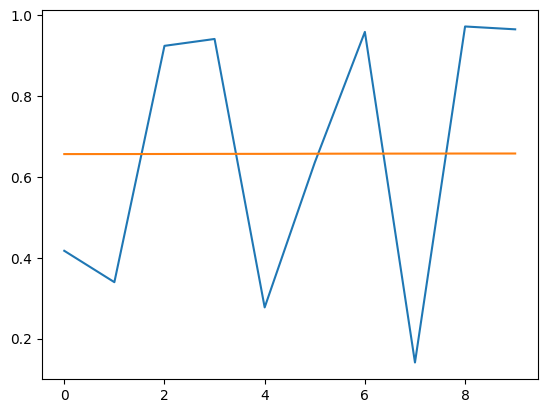

In [5]:
import jaxopt
from jaxopt import ProjectedGradient

def pava_jaxopt(x, gamma):
    
    def _objective(y):
        return jnp.sum((x-y)**2)
    
    # make first difference matrix
    N = x.shape[0]
    G = - jnp.eye(N) + jnp.diag(gamma * jnp.ones(N-1), k=1)
    A = jnp.zeros((N,N))
    b = jnp.zeros(N,)
    h = jnp.zeros(N)
    
    projection = lambda y, hparams: jaxopt.projection.projection_polyhedron(
        y, hparams, check_feasible=False)
    
    solver = ProjectedGradient(fun=_objective,
                             projection=projection,
                             tol=1e-6, maxiter=100)
    
    y_init = x.copy()
    return solver.run(y_init, hyperparams_proj=(A, b, G, h)).params
    
a = np.random.rand(10)
a_fit = pava_jaxopt(a, 1.0)
plt.plot(a)
plt.plot(a_fit)
    

In [17]:
def add_photocurrents_to_expt(key, expt, pc_shape_params=None,
        frac_pc_cells=0.1, opsin_mean=0.5, opsin_std=0.2,
        stim_dur_ms=5.0, pc_response_var=0.01, pc_window_len_ms=200,
        prior_context=100, response_length=900):
    """Add photocurrents to a continuous experiment generated by circuitmap"""

    # Draw opsin expression from zero-inflated gamma.
    # The vector opsin_expression determines the _average_ amplitude
    # of an evoked photocurrent when stimulating that cell
    N, K = expt['stim_matrix'].shape
    pc_cells = np.random.choice(N, int(frac_pc_cells*N), replace=False)
    opsin_expression = np.zeros(N)
    opsin_expression[pc_cells] = np.random.gamma(shape=(opsin_mean/opsin_std)**2, scale=opsin_std**2/opsin_mean, size=len(pc_cells))
        
    # Draw actual evoked photocurrent heights centered around their average
    pc_contributions = pc_response_var * (
            np.random.randn(N, K) * (opsin_expression[:, None] > 0)) + opsin_expression[:,None]

    if pc_shape_params is None:
        pc_shape_params = dict(
            O_inf_min=0.3,
                O_inf_max=1.0,
                R_inf_min=0.1,
                R_inf_max=1.0,
                tau_o_min=6,
                tau_o_max=25,
                tau_r_min=5,
                tau_r_max=16, 
            )

    pc_full_params = dict(
        onset_jitter_ms=0.01,
        onset_latency_ms=0.0,
        pc_shape_params=pc_shape_params,
        add_target_gp=False,
        target_gp_lengthscale=20,
        target_gp_scale=0.01,
        linear_onset_frac=1.0,
        msecs_per_sample=0.05,
        stim_start=0.0,
        stim_end=stim_dur_ms,
        isi_ms=30,
        window_len_ms=pc_window_len_ms,
    )
   
    # Get a PC shape for every stim
    stim_mat_scaled = expt['stim_matrix'] / np.max(expt['stim_matrix'])
    jittered_pc_shapes = np.array(sample_jittered_photocurrent_shapes(key, K, **pc_full_params)[1])
    true_photocurrents = np.sum(stim_mat_scaled * pc_contributions, axis=0)[:,None] * jittered_pc_shapes
    
    # Add photocurrents to unrolled trace to capture inter-trial overlap
    obs_flat = unfold_to_flat(expt['obs_responses'],
                    response_length=response_length, prior_context=prior_context,
                        stim_freq=stim_freq, sampling_freq=sampling_freq)
    
    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, K * isi, isi) + prior_context
   
    print(stim_times)
    print(true_photocurrents.shape)
    for i,stim_idx in enumerate(stim_times):
        _end_idx = stim_idx + response_length
        end_idx_flat = np.minimum(_end_idx, len(obs_flat))
        end_idx_wrapped = jittered_pc_shapes.shape[1] - np.maximum(_end_idx - len(obs_flat), 0)
        obs_flat[stim_idx:end_idx_flat] += true_photocurrents[i,:end_idx_wrapped]
       
    expt['obs_with_photocurrents'] = fold_overlapping(obs_flat, prior_context, response_length)
    expt['true_photocurrents'] = true_photocurrents
    return expt

# @partial(jax.jit, static_argnames=('stim_start', 
#                               'const_baseline',
#                                    'decaying_baseline', 'max_iters', 'rank'), backend='cpu')
def coordinate_descent_nmu(traces,
                           stim_start=100,
                           const_baseline=True,
                           decaying_baseline=True,
                           rank=1,
                           update_U=True,
                           update_V=True,
                           max_iters=100,
                           tol=1e-4,
                           gamma=0.999):

    def _update_factors(i, outer_state):

        # unpack outer state
        U_photo, V_photo, U_base, V_base, beta, loss = outer_state

        # update decaying baseline if active
        if decaying_baseline:
            resid = traces - U_photo @ V_photo - beta
            U_base, V_base, _, _ = _rank_one_nmu_decreasing(resid, (U_base, V_base),
                                                             maxiter=500)

        # update constant baseline if active
        if const_baseline:
            beta = jnp.min(traces - U_photo @ V_photo - U_base @ V_base, axis=1, keepdims=True)
            beta = jnp.maximum(beta, 0)

        # update rank-r approximation of the photocurrent component, 
        # stored in U_photo and V_photo. Use lax.scan to update each
        # rank-one component in turn
        def _scan_inner(resid, curr_init_factors):
            U_i_init, V_i_init = curr_init_factors
            U_i_init = U_i_init[:, None]
            V_i_init = V_i_init[None, :]
            resid = resid + U_i_init @ V_i_init
            U_i, V_i, _, _, = _rank_one_nmu(
                resid,
                (U_i_init, V_i_init),
                update_U=update_U,
                update_V=update_V,
                baseline=False,
            )
            resid = resid - U_i @ V_i
            return resid, (jnp.squeeze(U_i), jnp.squeeze(V_i))

        resid = traces - U_photo @ V_photo - U_base @ V_base - beta
        _, (U_photo_T, V_photo) = jax.lax.scan(
            _scan_inner,
            resid,
            (U_photo.T, V_photo),
        )
        U_photo = U_photo_T.T
        loss = loss.at[i].set(
            jnp.linalg.norm(traces - U_photo @ V_photo - U_base @ V_base - beta)
        )
        return U_photo, V_photo, U_base, V_base, beta, loss


    
    # Initialize U, V, and beta using period before stim for initializing the
    # baseline terms
    if decaying_baseline:
        U_pre, V_pre = _nonnegsvd_init(traces[:, 0:stim_start], rank=1)
        V_pre_init = jnp.linalg.lstsq(U_pre, traces)[0]

        V_pre = subtractr.pava.pava_decreasing(
            jnp.squeeze(V_pre_init), gamma=gamma)[None, :]
        
    else:
        U_pre, V_pre = jnp.zeros((traces.shape[0], 1)), jnp.zeros((1, traces.shape[1]))

    U_photo, V_photo = _nonnegsvd_init(
        jnp.maximum(traces - U_pre @ V_pre, 0), rank=rank
    )
    
    if const_baseline:
        beta = jnp.min(traces - U_pre @ V_pre - U_photo @ V_photo, axis=1, keepdims=True)
        beta = jnp.maximum(0, beta)
    else:
        beta = jnp.zeros((traces.shape[0], 1))

    loss = jnp.zeros(max_iters)
    outer_state = (U_photo, V_photo, U_pre, V_pre, beta, loss)
    outer_state = jax.lax.fori_loop(0, max_iters, _update_factors, outer_state)
    U_photo, V_photo, U_pre, V_pre, beta, loss = outer_state

    U = jnp.concatenate((U_pre, U_photo), axis=1)
    V = jnp.concatenate((V_pre, V_photo), axis=0)

    return U, V, beta, loss


@partial(jax.jit, static_argnames=('stim_start', 'stim_end', 'dec_start', 'gamma'))
def estimate_photocurrents(traces,
                               stim_start=100, stim_end=200, dec_start=500, gamma=0.999):
    """Estimate photocurrents using non-negative matrix underapproximation.

    Parameters
    ----------
    traces : array-like
        Traces to estimate photocurrents from. Shape is (n_traces, n_timepoints).
    stim_start : int
        Index of first timepoint of stimulus.
    stim_end : int
        Index of last timepoint of stimulus.
    constrain_V : bool
        If True, constrain the estimated V using the underapprox constraint.
    rank : int
        Rank of the estimated matrix.

    Returns
    -------
    U : array-like
        Estimated U matrix. Shape is (n_traces, rank).
    V : array-like
        Estimated V matrix. Shape is (rank, n_timepoints).
    beta : array-like
        Estimated baseline term. Shape is (n_traces, 1).
    """
    cpus = jax.devices('cpu')
    gpus = jax.devices('gpu')
    
    # Create dummy initial factors
    # to use SVD initialization inside _rank_one_nmu
    traces = jnp.maximum(0, traces)

    # Fit 3 terms to the very beginning of the matrix:
    # decaying baseline, constant baseline, and photocurrent
    U_stim, V_stim, beta, loss = coordinate_descent_nmu(
        traces[:,0:stim_end],
        const_baseline=True,
        decaying_baseline=True,
        rank=1,
        max_iters=1,
    )

    
    # The first component of U_stim, V_stim corresponds to the decaying baseline
    traces = traces - beta
    U_dec = U_stim[:,0:1]
    V_dec_full_init = jnp.linalg.lstsq(U_dec, traces)[0]
    _, V_dec, _, _ = _rank_one_nmu(traces, init_factors=(U_dec, V_dec_full_init),
                                  update_U=False, update_V=True)
    
    # MOVE
    U_dec = jax.device_put(U_dec, cpus[0])
    V_dec = jax.device_put(V_dec, cpus[0])
    traces = jax.device_put(traces, cpus[0])
    
    _, V_dec, _, _ = _rank_one_nmu_decreasing(traces,
                        init_factors=(U_dec, V_dec),
                        update_U=False, update_V=True,
                        dec_start=0, gamma=gamma, maxiter=500)
    
    traces = jax.device_put(traces, gpus[0])
    
    # subtract away decaying baseline
    traces = traces - U_dec @ V_dec
    
    # Now fit photocurrent and output estimate.
    # We force our photocurrent estimate to be decreasing after dec_start
    U_photo = U_stim[:, 1:2]
    V_photo = jnp.linalg.lstsq(U_photo, traces[:, stim_start:])[0]    
    _, V_photo, _, _ = _rank_one_nmu(traces[:, stim_start:],
                                    init_factors=(U_photo, V_photo),
                                    update_U=False, update_V=True)
    
    # MOVE
    U_photo = jax.device_put(U_dec, cpus[0])
    V_photo = jax.device_put(V_photo, cpus[0])
    traces = jax.device_put(traces, cpus[0])
    
    _, V_photo, _, _ = _rank_one_nmu_decreasing(traces[:, stim_start:],
                        init_factors=(U_photo, V_photo),
                        update_U=False, update_V=True, dec_start=dec_start, gamma=gamma,
                                               maxiter=500)
    
    # pad V with zeros to account for the time before stim_start
    V_photo = jnp.concatenate((jnp.zeros((1, stim_start)), V_photo), axis=1)
    return U_photo, V_photo, U_dec, V_dec, beta

def fold_overlapping(trace, prior_context, response_length):
    """
    Split trace into overlapping segments of length response_length.
    prior_context determines the amount which is overlapped from the prior trial
    """
    num_samples = trace.shape[0]
    isi = int(sampling_freq / stim_freq)
    start_indices = np.arange(0, num_samples - response_length + prior_context, isi)

    end_indices = start_indices + response_length
    return np.array([trace[x:y] for x,y in zip(start_indices, end_indices)])

def unfold_to_flat(traces, response_length=900, prior_context=100, stim_freq=30, sampling_freq=20000):
    response_length = traces.shape[1]
    
    next_stim_idx = prior_context + int(sampling_freq / stim_freq)
    next_stim_idx = np.minimum(next_stim_idx, response_length-1)
    
        
    # include prior context on first trace, after that we leave it off
    flattened = np.concatenate(traces[:, prior_context:next_stim_idx])
    flattened = np.concatenate((traces[0, 0:prior_context], flattened, traces[-1,next_stim_idx:]))
    
    return flattened
    
    
def subtract_overlapping_trials(orig, est,
            prior_context=100, stim_freq=30, sampling_freq=20000):
    
    
    # compute stim times based on prior context and response length
    num_stims, response_length = orig.shape
    
    obs_flat = unfold_to_flat(orig, response_length=response_length,
                    prior_context=prior_context, stim_freq=stim_freq,
                              sampling_freq=sampling_freq)
    

    isi = int(sampling_freq / stim_freq)
    stim_times = np.arange(0, num_stims * isi, isi)
   
    num_samples = obs_flat.shape[0]
    subtracted_flat = obs_flat.copy()
    for stim_idx, pc_est in zip(stim_times, est):
        end_idx = stim_idx + response_length
        
        # check whether we're at the end of the trace
        if end_idx > num_samples:
            est_cutoff = end_idx - num_samples
            end_idx = num_samples
            subtracted_flat[stim_idx:end_idx] -= pc_est[:est_cutoff]
            
#             len_remaining = num_samples - stim_idx
#             subtracted_flat[stim_idx:] = pc_est[prior_context:prior_context + len_remaining]
            continue
        else:
            subtracted_flat[stim_idx:end_idx] -= pc_est
    subtracted = fold_overlapping(subtracted_flat, prior_context, response_length)
    return subtracted


## benchmarking the coordinate descent step


In [18]:
# generate expt
key = jax.random.PRNGKey(0)
expt = add_photocurrents_to_expt(key, expt, stim_dur_ms=stim_dur_ms,
    prior_context=prior_context, response_length=response_length,
                                 frac_pc_cells=0.05,
                                 pc_window_len_ms=(response_length / sampling_freq * 1e3))

[  100   766  1432  2098  2764  3430  4096  4762  5428  6094  6760  7426
  8092  8758  9424 10090 10756 11422 12088 12754 13420 14086 14752 15418
 16084 16750 17416 18082 18748 19414 20080 20746 21412 22078 22744 23410
 24076 24742 25408 26074 26740 27406 28072 28738 29404 30070 30736 31402
 32068 32734 33400 34066 34732 35398 36064 36730 37396 38062 38728 39394
 40060 40726 41392 42058 42724 43390 44056 44722 45388 46054 46720 47386
 48052 48718 49384 50050 50716 51382 52048 52714 53380 54046 54712 55378
 56044 56710]
(86, 1800)


CPU times: user 12.1 s, sys: 3.02 s, total: 15.2 s
Wall time: 17.1 s


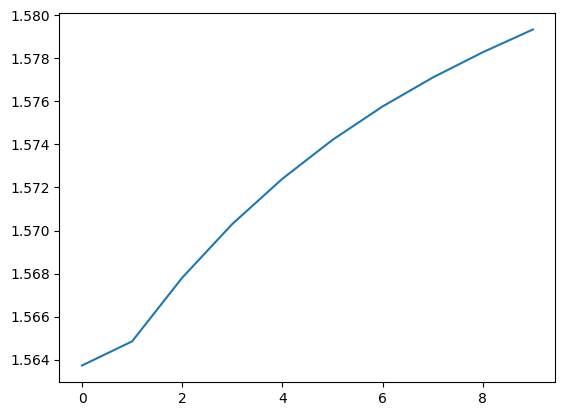

In [15]:
traces = expt['obs_with_photocurrents']
%time U, V, beta, loss = coordinate_descent_nmu(traces[:,0:200], rank=1, max_iters=10); U.block_until_ready()
plt.plot(loss)
plt.show()

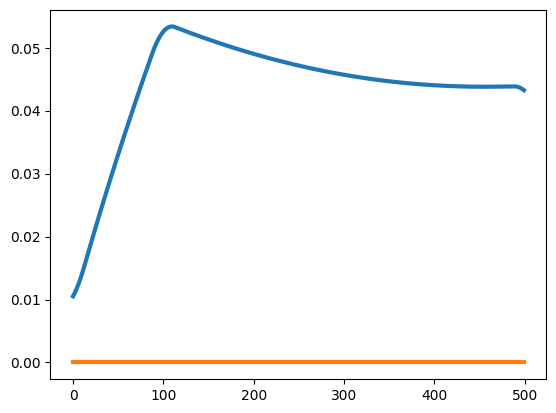

In [35]:
init_test = expt['true_photocurrents'][:, 0:500] + np.random.rand(expt['true_photocurrents'].shape[0])[:, None] * (
    expt['true_photocurrents'][:, 600:100:-1])
U_init, V_init = _nonnegsvd_init(init_test, rank=2)
# plt.plot(V_init.T)
# plt.plot(init_test.T)
plt.plot(V_init.T, linewidth=3)

## Run full subtraction on sim experiment


In [19]:
U_photo, V_photo, U_base, V_base = estimate_photocurrents(expt['obs_with_photocurrents'])

ValueError: too many values to unpack (expected 4)

In [ ]:
subtracted = subtract_overlapping_trials(expt['obs_with_photocurrents'], photo_est,
                    prior_context=prior_context, stim_freq=stim_freq,)

fig, axs = plt.subplots(1, 4, figsize=(12,3), dpi=200)
axs[0].plot(expt['obs_with_photocurrents'].T)
axs[1].plot(photo_est.T)
axs[2].plot(subtracted.T)
axs[3].plot((expt['obs_with_photocurrents'] - photo_est).T)
plt.show()

In [ ]:
jax.devices("gpu")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200, sharey=True)
axs[0].plot(photo_est[:, prior_context:].T)
axs[1].plot(expt['true_photocurrents'].T)
plt.show()

## Comparing previous trial strategies
- strategy 1: use overlapping window to subtract next-trial effects
- strategy 2: estimate previous trial effects using only a small amount of prior context

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,3))
plot_start = prior_context - 100
plot_end = prior_context + 500

# For this comparison, we'll most likely see differences between the two strategies
# on trials which have a larger transient at the beginning of the trial, so subset to those for now.
idxs = np.argsort(
    np.sum(
        expt['obs_with_photocurrents'][:,0:prior_context],
        axis=-1,
    )
)[::-1]
top_idxs = idxs[0:20]

axs[0,0].plot(expt['obs_with_photocurrents'][top_idxs,0:plot_end].T)
axs[0,0].set_title('Original')

axs[0,1].plot(subtracted[top_idxs, plot_start:plot_end].T)
axs[0,1].set_title('Overlapping subtraction')

single_trial_subtracted = expt['obs_with_photocurrents'] - photo_est - base_est
axs[0,2].plot(single_trial_subtracted[top_idxs, plot_start:plot_end].T)
axs[0,2].set_title('Single trial subtraction')

axs[0,3].plot(expt['obs_responses'][top_idxs,plot_start:plot_end].T)
axs[0,3].set_title('Ground truth')

# plot results after demixing
demixer = NeuralDemixer(path='../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt')
demixed_original = demixer(np.array(expt['obs_with_photocurrents'][:, 0:900]))
demixed_overlapping = demixer(np.array(subtracted[:, 0:900]))
demixed_singletrial = demixer(np.array(single_trial_subtracted[:, 0:900]))
demixed_gt = demixer(np.array(expt['obs_responses'][:, 0:900]))

axs[1,0].plot(demixed_original[top_idxs,0:plot_end].T)
axs[1,0].set_title('dem. original')

axs[1,1].plot(demixed_overlapping[top_idxs, plot_start:plot_end].T)
axs[1,1].set_title('dem. overlapping')

axs[1,2].plot(demixed_singletrial[top_idxs, plot_start:plot_end].T)
axs[1,2].set_title('dem. single trial')

axs[1,3].plot(demixed_gt[top_idxs,plot_start:plot_end].T)
axs[1,3].set_title('dem. gt')

for ax in axs.ravel():
    ax.axvline(x=100, linestyle='-.', color='grey')
    ax.axvline(x=200, linestyle='-.', color='grey')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(photo_est[:, plot_start:plot_end].T)
plt.plot(base_est[:,plot_start:plot_end].T)
plt.show()

In [ ]:
traces = expt['obs_with_photocurrents']
stim_end=200
U_stim, V_stim, beta, loss = coordinate_descent_nmu(
        traces[:,0:stim_end],
        const_baseline=True,
        decaying_baseline=True,
        rank=1,
        max_iters=2,
    )
plt.plot((U_stim @ V_stim + beta).T)
plt.show()

In [ ]:
plt.plot((U_stim[:,0:1] @ V_stim[0:1,:]).T, )
plt.plot((U_stim[:,1:2] @ V_stim[1:2,:]).T,)
# plt.plot(expt['obs_with_photocurrents'][:,0:200].T, color='blue', alpha=0.4)
plt.show()

In [ ]:
plt.plot(expt['obs_with_photocurrents'][:,0:200].T)
plt.show()

In [ ]:
plt.plot(loss)

In [ ]:
loss